In [1]:
import sage_data_client
import matplotlib.pyplot as plt
import pandas as pd
from metpy.calc import dewpoint_from_relative_humidity, wet_bulb_temperature
from metpy.units import units
from PIL import Image
import numpy as np

from matplotlib.dates import DateFormatter

In [15]:
# Query the SAGE data client to access the data; use 'name' filter
#this takes a LONG time when doing more than a day

df_temp = sage_data_client.query(start="2023-04-16T12:00:00Z",
                                 end="2023-04-19T23:00:00Z", 
                                    filter={
                                        "name" : 'wxt.env.temp|wxt.env.humidity|wxt.env.pressure',
                                        "plugin" : "registry.sagecontinuum.org/jrobrien/waggle-wxt536.*",
                                        "vsn" : "W057",
                                        "sensor" : "vaisala-wxt536"
                                    }
)

In [16]:
# Query the SAGE data client to access the data; use 'name' filter
#this takes a LONG time when doing more than a day

winds = sage_data_client.query(start="2023-04-16T12:00:00Z",
                                 end="2023-04-19T23:00:00Z", 
                                    filter={
                                        "name" : 'wxt.wind.speed|wxt.wind.direction',
                                        "plugin" : "registry.sagecontinuum.org/jrobrien/waggle-wxt536.*",
                                        "vsn" : "W057",
                                        "sensor" : "vaisala-wxt536"
                                    }
)


In [4]:
hums = df_temp[df_temp['name']=='wxt.env.humidity']
temps = df_temp[df_temp['name']=='wxt.env.temp']
pres = df_temp[df_temp['name']=='wxt.env.pressure']

npres = len(pres)
nhum = len(hums)
ntemps = len(temps)
print(npres, nhum, ntemps)
minsamps = min([nhum, ntemps, npres])

vals = temps.set_index('timestamp')[0:minsamps]
vals['temperatures'] = vals.value.to_numpy()[0:minsamps]
vals['humidity'] = hums.value.to_numpy()[0:minsamps]
vals['pressure'] = pres.value.to_numpy()[0:minsamps]


1519407 1517958 1520950


In [5]:
direction = winds[winds['name']=='wxt.wind.direction']
speed = winds[winds['name']=='wxt.wind.speed']

nspeed = len(speed)
ndir = len(direction)
print(nspeed, ndir)
minsamps = min([nspeed, ndir])

windy = speed.set_index('timestamp')[0:minsamps]
windy['speed'] = windy.value.to_numpy()[0:minsamps]
windy['direction'] = direction.value.to_numpy()[0:minsamps]


winds10mean = windy.resample('60S').mean(numeric_only=True).ffill()
winds10max = windy.resample('60S').max(numeric_only=True).ffill()

1524779 1523278


In [6]:
dp = dewpoint_from_relative_humidity( vals.temperatures.to_numpy() * units.degC, 
                                     vals.humidity.to_numpy() * units.percent)

vals['dewpoint'] = dp

In [7]:
#vals10 = vals.fillna('nearest').resample('10S').mean(numeric_only=True)
vals10 = vals.resample('10S').mean(numeric_only=True).ffill() #ffil gets rid of nans due to empty resample periods

#vals10['pydatetime'] = vals10.index.to_pydatetime()
#vals10 = vals10.set_index('pydatetime')

In [8]:
vals10

,value,temperatures,humidity,pressure,dewpoint
timestamp,,,,,
2023-04-16 12:00:00+00:00,8.5,8.5,98.849600,974.600000,8.329339
2023-04-16 12:00:10+00:00,8.5,8.5,98.830469,974.617969,8.326486
2023-04-16 12:00:20+00:00,8.5,8.5,98.802290,974.602290,8.322285
2023-04-16 12:00:30+00:00,8.5,8.5,98.800000,974.721538,8.321943
2023-04-16 12:00:40+00:00,8.5,8.5,98.800000,974.610000,8.321943
...,...,...,...,...,...
2023-04-17 20:24:50+00:00,2.8,2.8,66.366154,979.063077,-2.847873
2023-04-17 20:25:00+00:00,2.8,2.8,66.069531,979.096875,-2.908151
2023-04-17 20:25:10+00:00,2.8,2.8,65.711628,979.100000,-2.981216


In [9]:
wb = wet_bulb_temperature(vals10.pressure.to_numpy() * units.hPa,
                          vals10.temperatures.to_numpy() * units.degC,
                          vals10.dewpoint.to_numpy() * units.degC)

vals10['wetbulb'] = wb

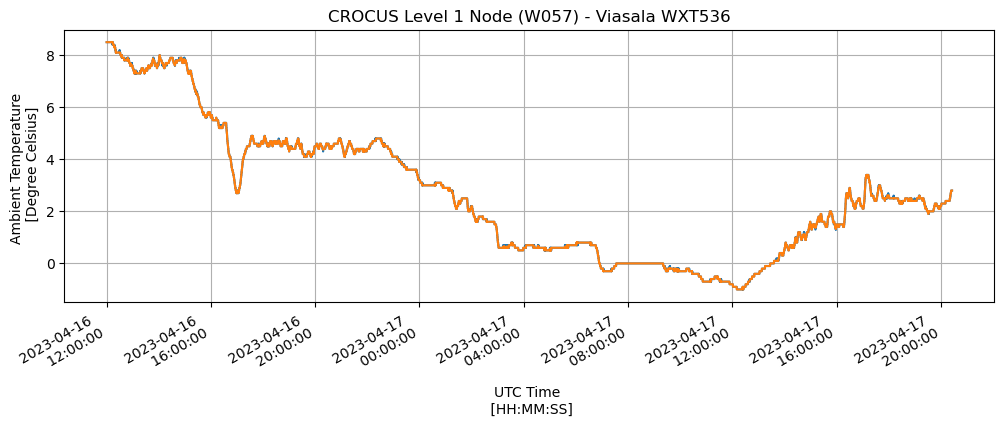

In [10]:
fig, axs = plt.subplots(figsize=(12, 4))

# Define Format of how the date is displayed
date_form = DateFormatter("%Y-%m-%d \n %H:%M:%S")

# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
vals.temperatures.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Viasala WXT536',
                                          ax=axs
                                          )

vals10.temperatures.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Viasala WXT536',
                                          ax=axs
                                          )


axs.xaxis.set_major_formatter(date_form)
axs.grid(True)

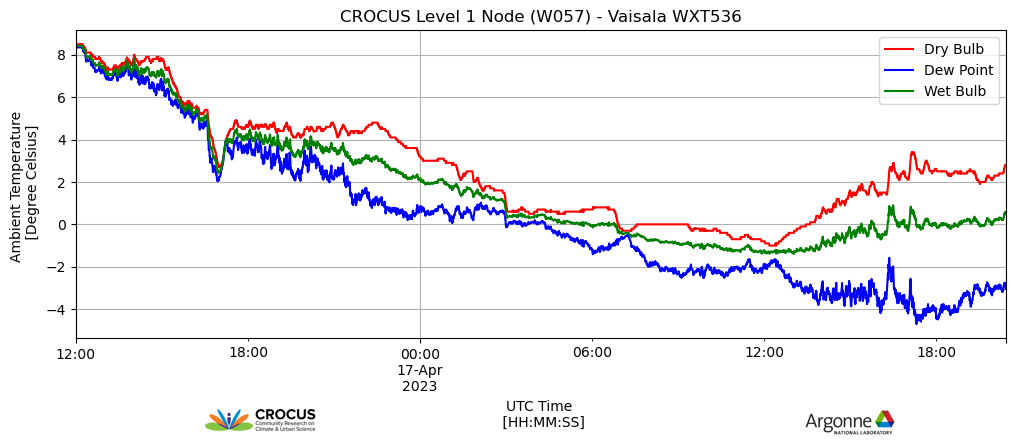

In [11]:
fig, axs = plt.subplots(figsize=(12, 4))

# Define Format of how the date is displayed
date_form = DateFormatter("%Y-%m-%d \n %H:%M")

# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
vals10.temperatures.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                          ax=axs, color='r', label='Dry Bulb'
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
vals10.dewpoint.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                          ax=axs, color='b', label='Dew Point'
                                          )


vals10.wetbulb.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                          ax=axs, color='g', label='Wet Bulb'
                                          )


#axs.xaxis.set_major_formatter(date_form)

im = Image.open('Argonnelablogo.PNG')

im.thumbnail([im.size[0]/12, im.size[1]/12])
height = im.size[1]
width = im.size[0]
fig.figimage(im, 800  , 0)

im2 = Image.open('cr.png')

im2.thumbnail([im2.size[0]/4, im2.size[1]/4])
height = im2.size[1]
width = im2.size[0]
fig.figimage(im2, 200  , -20, zorder=-1)
#axs.xaxis.set_major_formatter(date_form)

plt.legend()
axs.grid(True)

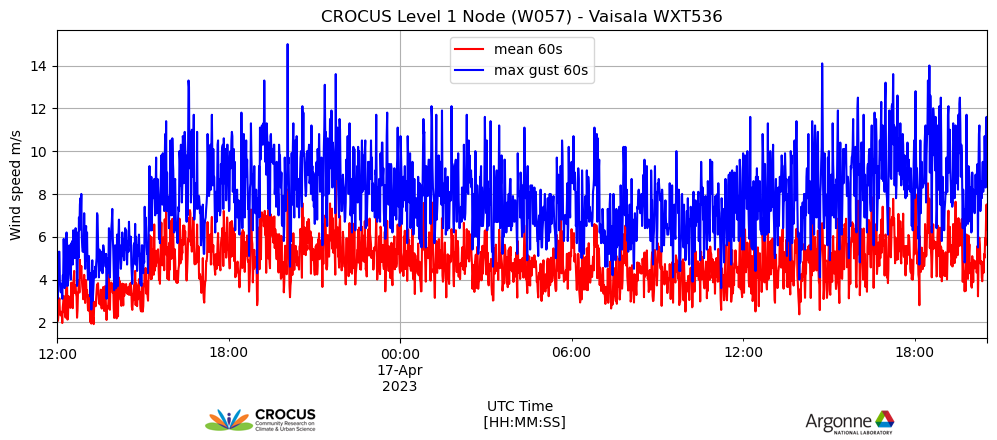

In [12]:
fig, axs = plt.subplots(figsize=(12, 4))

# Define Format of how the date is displayed
date_form = DateFormatter("%Y-%m-%d \n %H:%M")

# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
winds10mean.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed m/s',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                          ax=axs, color='r', label='mean 60s'
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
winds10max.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed m/s',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                          ax=axs, color='b', label='max gust 60s'
                                          )



#axs.xaxis.set_major_formatter(date_form)

im = Image.open('Argonnelablogo.PNG')

im.thumbnail([im.size[0]/12, im.size[1]/12])
height = im.size[1]
width = im.size[0]
fig.figimage(im, 800  , 0)

im2 = Image.open('cr.png')

im2.thumbnail([im2.size[0]/4, im2.size[1]/4])
height = im2.size[1]
width = im2.size[0]
fig.figimage(im2, 200  , -20, zorder=-1)
#axs.xaxis.set_major_formatter(date_form)

plt.legend()
axs.grid(True)

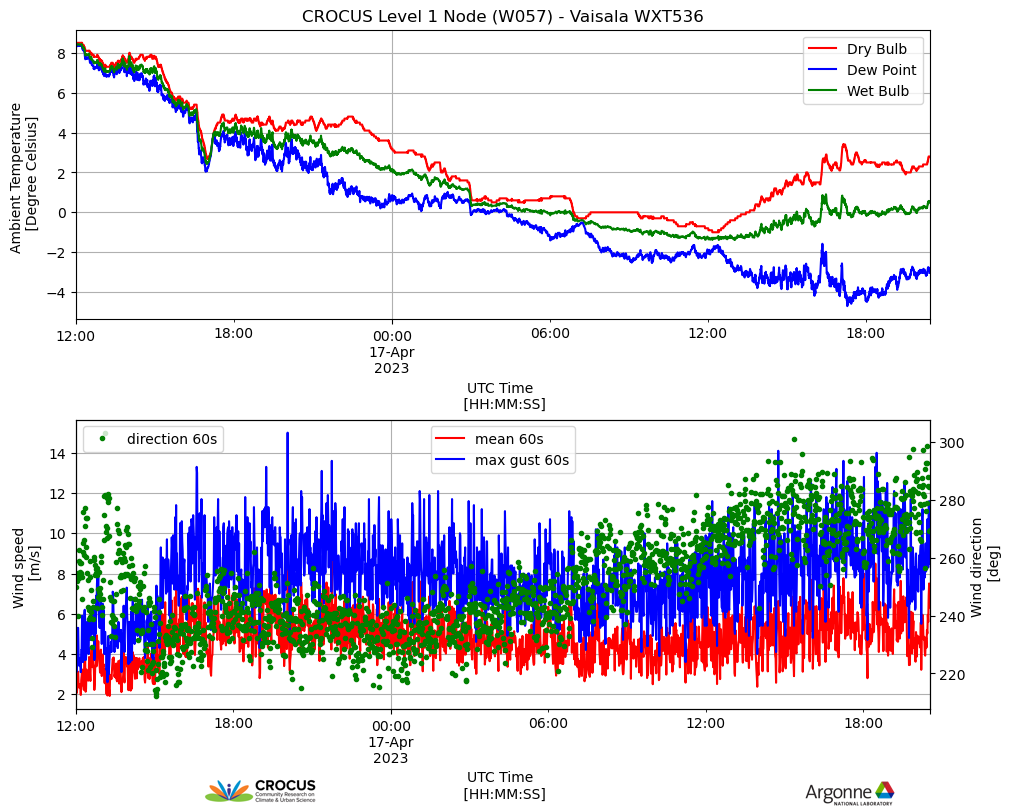

In [13]:
fig, axs = plt.subplots( ncols=1, nrows=2, figsize=[10,8], constrained_layout=True)
vals10.temperatures.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                          ax=axs[0], color='r', label='Dry Bulb',
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
vals10.dewpoint.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                           color='b', label='Dew Point',
                                          ax=axs[0])


vals10.wetbulb.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                          color='g', label='Wet Bulb',
                                          ax=axs[0])

axs[0].legend()
axs[0].grid(True)

winds10mean.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed m/s',
                                          title='',
                                          ax=axs[1], color='r', label='mean 60s'
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
winds10max.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed \n [m/s]',
                                          title='',
                                          ax=axs[1], color='b', label='max gust 60s'
                                          )
axs[1].legend()
axs[1].grid(True)

ytwin = plt.twinx()

winds10mean.direction.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind direction \n [deg]',
                                          title='',
                                          ax=ytwin, color='g', label='direction 60s',
                                          marker='.', linestyle='none')

ytwin.legend(loc=2)

im = Image.open('Argonnelablogo.PNG')

im.thumbnail([im.size[0]/12, im.size[1]/12])
height = im.size[1]
width = im.size[0]
fig.figimage(im, 800  , 0)

im2 = Image.open('cr.png')

im2.thumbnail([im2.size[0]/4, im2.size[1]/4])
height = im2.size[1]
width = im2.size[0]
fig.figimage(im2, 200  , -20, zorder=-1)
#axs.xaxis.set_major_formatter(date_form)


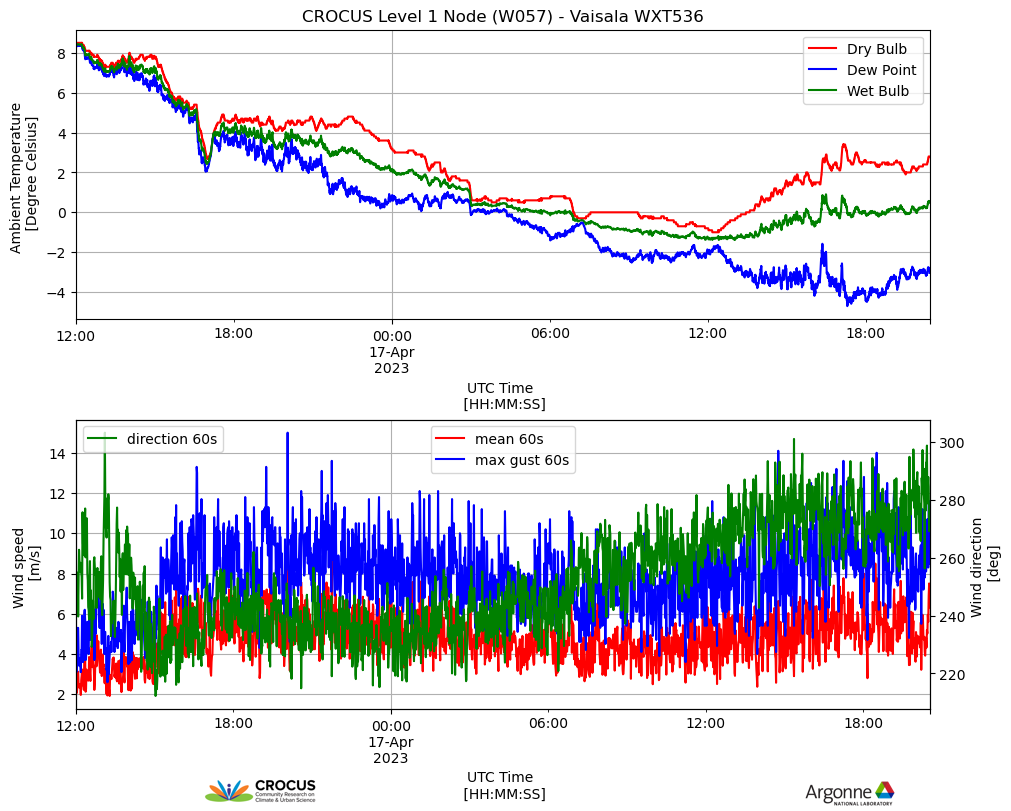

In [14]:
time1 = None #pd.Timestamp("2023-04-14 08:00:00")
time2 = None #pd.Timestamp("2023-04-14 17:00:00")
fig, axs = plt.subplots( ncols=1, nrows=2, figsize=[10,8], constrained_layout=True)
vals10.temperatures.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                          ax=axs[0], color='r', label='Dry Bulb',
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
vals10.dewpoint.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                           color='b', label='Dew Point',
                                          ax=axs[0])


vals10.wetbulb.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                          color='g', label='Wet Bulb',
                                          ax=axs[0])

axs[0].legend()
axs[0].grid(True)

axs[0].set_xlim([time1, time2])


winds10mean.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed m/s',
                                          title='',
                                          ax=axs[1], color='r', label='mean 60s'
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
winds10max.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed \n [m/s]',
                                          title='',
                                          ax=axs[1], color='b', label='max gust 60s'
                                          )
axs[1].legend()
axs[1].grid(True)


axs[1].set_xlim([time1, time2])

ytwin = plt.twinx()

winds10mean.direction.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind direction \n [deg]',
                                          title='',
                                          ax=ytwin, color='g', label='direction 60s'
                                          )

ytwin.legend(loc=2)

ytwin.set_xlim([time1, time2])

im = Image.open('Argonnelablogo.PNG')

im.thumbnail([im.size[0]/12, im.size[1]/12])
height = im.size[1]
width = im.size[0]
fig.figimage(im, 800  , 0)

im2 = Image.open('cr.png')

im2.thumbnail([im2.size[0]/4, im2.size[1]/4])
height = im2.size[1]
width = im2.size[0]
fig.figimage(im2, 200  , -20, zorder=-1)
#axs.xaxis.set_major_formatter(date_form)
